# Predicting Animal Adoptions

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 25)
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, plot_confusion_matrix

## Data Exploration and Merging

In [2]:
df_in = pd.read_csv('data/Austin_Animal_Center_Intakes_080422.csv', 
                    parse_dates=['DateTime'])
df_in = df_in.sort_values(by='DateTime')
df_in.head()

,Animal ID,Name,DateTime,MonthYear,Found Location,Intake Type,Intake Condition,Animal Type,Sex upon Intake,Age upon Intake,Breed,Color
73012,A521520,Nina,2013-10-01 07:51:00,October 2013,Norht Ec in Austin (TX),Stray,Normal,Dog,Spayed Female,7 years,Border Terrier/Border Collie,White/Tan
39003,A664235,NaN,2013-10-01 08:33:00,October 2013,Abia in Austin (TX),Stray,Normal,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White
2383,A664237,NaN,2013-10-01 08:33:00,October 2013,Abia in Austin (TX),Stray,Normal,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White
115994,A664236,NaN,2013-10-01 08:33:00,October 2013,Abia in Austin (TX),Stray,Normal,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White
117740,A664233,Stevie,2013-10-01 08:53:00,October 2013,7405 Springtime in Austin (TX),Stray,Injured,Dog,Intact Female,3 years,Pit Bull Mix,Blue/White


In [3]:
df_out = pd.read_csv('data/Austin_Animal_Center_Outcomes_080422.csv', 
                     parse_dates=['DateTime'])
df_out = df_out.sort_values(by='DateTime')
df_out.head()

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
60248,A659834,*Dudley,2013-10-01 09:31:00,Oct 2013,07/23/2013,Adoption,Foster,Dog,Neutered Male,2 months,Labrador Retriever Mix,Black
49629,A664235,NaN,2013-10-01 10:39:00,Oct 2013,09/24/2013,Transfer,Partner,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White
108106,A664237,NaN,2013-10-01 10:44:00,Oct 2013,09/24/2013,Transfer,Partner,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White
91636,A664236,NaN,2013-10-01 10:44:00,Oct 2013,09/24/2013,Transfer,Partner,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White
11937,A664223,Moby,2013-10-01 11:03:00,Oct 2013,09/30/2009,Return to Owner,NaN,Dog,Neutered Male,4 years,Bulldog Mix,White


In [4]:
# Create iterative counts for animals that have multiple intakes/outcomes
df_in['Intake Num'] = df_in.groupby('Animal ID', sort=False).cumcount()+1
df_out['Outcome Num'] = df_out.groupby('Animal ID', sort=False).cumcount()+1

In [5]:
# Checking a known repeat offender
df_in.loc[df_in['Animal ID'] == 'A721033'].tail(5)

,Animal ID,Name,DateTime,MonthYear,Found Location,Intake Type,Intake Condition,Animal Type,Sex upon Intake,Age upon Intake,Breed,Color,Intake Num
52717,A721033,Lil Bit,2019-04-26 10:28:00,April 2019,South 1St And Stassney in Austin (TX),Public Assist,Normal,Dog,Neutered Male,3 years,Rat Terrier Mix,Tricolor/Brown Brindle,29
12761,A721033,Lil Bit,2019-05-20 10:18:00,May 2019,1819 South Pleasant Valley Road in Austin (TX),Public Assist,Normal,Dog,Neutered Male,4 years,Rat Terrier Mix,Tricolor/Brown Brindle,30
36609,A721033,Lil Bit,2019-08-05 10:52:00,August 2019,Burton And Oltorf in Austin (TX),Public Assist,Normal,Dog,Neutered Male,4 years,Rat Terrier Mix,Tricolor/Brown Brindle,31
100219,A721033,Lil Bit,2019-09-16 14:06:00,September 2019,Justin Lane And North Lamar in Austin (TX),Public Assist,Normal,Dog,Neutered Male,4 years,Rat Terrier Mix,Tricolor/Brown Brindle,32
27818,A721033,Lil Bit,2019-10-05 12:31:00,October 2019,1135 Airport Boulevard in Austin (TX),Public Assist,Normal,Dog,Neutered Male,4 years,Rat Terrier Mix,Tricolor/Brown Brindle,33


In [6]:
df_out.loc[df_out['Animal ID'] == 'A721033'].tail(5)

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color,Outcome Num
28529,A721033,Lil Bit,2019-05-04 08:37:00,May 2019,05/20/2015,Return to Owner,NaN,Dog,Neutered Male,3 years,Rat Terrier Mix,Tricolor/Brown Brindle,29
18006,A721033,Lil Bit,2019-05-21 14:42:00,May 2019,05/20/2015,Return to Owner,NaN,Dog,Neutered Male,4 years,Rat Terrier Mix,Tricolor/Brown Brindle,30
4520,A721033,Lil Bit,2019-08-10 11:56:00,Aug 2019,05/20/2015,Return to Owner,NaN,Dog,Neutered Male,4 years,Rat Terrier Mix,Tricolor/Brown Brindle,31
62287,A721033,Lil Bit,2019-09-19 11:02:00,Sep 2019,05/20/2015,Return to Owner,NaN,Dog,Neutered Male,4 years,Rat Terrier Mix,Tricolor/Brown Brindle,32
66979,A721033,Lil Bit,2019-10-20 11:35:00,Oct 2019,05/20/2015,Rto-Adopt,NaN,Dog,Neutered Male,4 years,Rat Terrier Mix,Tricolor/Brown Brindle,33


In [7]:
df = df_in.merge(df_out, 
                 left_on=['Animal ID', 'Intake Num'], 
                 right_on=['Animal ID', 'Outcome Num'],
                 how='inner',
                 suffixes=("_in", "_out"))

In [8]:
df.head()

,Animal ID,Name_in,DateTime_in,MonthYear_in,Found Location,Intake Type,Intake Condition,Animal Type_in,Sex upon Intake,Age upon Intake,Breed_in,Color_in,Intake Num,Name_out,DateTime_out,MonthYear_out,Date of Birth,Outcome Type,Outcome Subtype,Animal Type_out,Sex upon Outcome,Age upon Outcome,Breed_out,Color_out,Outcome Num
0,A521520,Nina,2013-10-01 07:51:00,October 2013,Norht Ec in Austin (TX),Stray,Normal,Dog,Spayed Female,7 years,Border Terrier/Border Collie,White/Tan,1,Nina,2013-10-01 15:39:00,Oct 2013,09/07/2006,Return to Owner,NaN,Dog,Spayed Female,7 years,Border Terrier/Border Collie,White/Tan,1
1,A664235,NaN,2013-10-01 08:33:00,October 2013,Abia in Austin (TX),Stray,Normal,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White,1,NaN,2013-10-01 10:39:00,Oct 2013,09/24/2013,Transfer,Partner,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White,1
2,A664237,NaN,2013-10-01 08:33:00,October 2013,Abia in Austin (TX),Stray,Normal,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White,1,NaN,2013-10-01 10:44:00,Oct 2013,09/24/2013,Transfer,Partner,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White,1
3,A664236,NaN,2013-10-01 08:33:00,October 2013,Abia in Austin (TX),Stray,Normal,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White,1,NaN,2013-10-01 10:44:00,Oct 2013,09/24/2013,Transfer,Partner,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White,1
4,A664233,Stevie,2013-10-01 08:53:00,October 2013,7405 Springtime in Austin (TX),Stray,Injured,Dog,Intact Female,3 years,Pit Bull Mix,Blue/White,1,Stevie,2013-10-01 15:33:00,Oct 2013,09/30/2010,Euthanasia,Suffering,Dog,Intact Female,3 years,Pit Bull Mix,Blue/White,1


In [9]:
df.columns

Index(['Animal ID', 'Name_in', 'DateTime_in', 'MonthYear_in', 'Found Location',
       'Intake Type', 'Intake Condition', 'Animal Type_in', 'Sex upon Intake',
       'Age upon Intake', 'Breed_in', 'Color_in', 'Intake Num', 'Name_out',
       'DateTime_out', 'MonthYear_out', 'Date of Birth', 'Outcome Type',
       'Outcome Subtype', 'Animal Type_out', 'Sex upon Outcome',
       'Age upon Outcome', 'Breed_out', 'Color_out', 'Outcome Num'],
      dtype='object')

In [10]:
# Exploring rows where the simple iterative count didn't work 
# Aka the outcome date was before the intake date
dirty = df.loc[df['DateTime_in'] > df['DateTime_out']]

In [11]:
dirty.shape

(725, 25)

In [12]:
dirty = dirty[['Animal ID', 'DateTime_in', 'Intake Num']]

In [13]:
# Going to add 1 to intake num, then try to merge again
dirty['Intake Num'] += 1

In [14]:
dirty.head()

,Animal ID,DateTime_in,Intake Num
203,A663004,2013-10-04 14:11:00,2
288,A663572,2013-10-06 11:00:00,2
426,A663722,2013-10-09 12:11:00,2
427,A663723,2013-10-09 12:11:00,2
609,A663667,2013-10-12 17:17:00,2


In [15]:
df_in_clean = df_in.copy()

In [16]:
df_in_clean = df_in_clean.merge(dirty,
                                left_on=['Animal ID', 'DateTime'], 
                                right_on=['Animal ID', 'DateTime_in'], 
                                how='left',
                                suffixes=('_dirty', '_clean'))

In [17]:
df_in_clean = df_in_clean.drop(columns=['DateTime_in'])
df_in_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142796 entries, 0 to 142795
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Animal ID         142796 non-null  object        
 1   Name              100856 non-null  object        
 2   DateTime          142796 non-null  datetime64[ns]
 3   MonthYear         142796 non-null  object        
 4   Found Location    142796 non-null  object        
 5   Intake Type       142796 non-null  object        
 6   Intake Condition  142796 non-null  object        
 7   Animal Type       142796 non-null  object        
 8   Sex upon Intake   142795 non-null  object        
 9   Age upon Intake   142796 non-null  object        
 10  Breed             142796 non-null  object        
 11  Color             142796 non-null  object        
 12  Intake Num_dirty  142796 non-null  int64         
 13  Intake Num_clean  726 non-null     float64       
dtypes: d

In [18]:
df_in_clean['Intake Num'] = np.where(~df_in_clean['Intake Num_clean'].isna(),
                                     df_in_clean['Intake Num_clean'],
                                     df_in_clean['Intake Num_dirty'])

In [19]:
df_in_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142796 entries, 0 to 142795
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Animal ID         142796 non-null  object        
 1   Name              100856 non-null  object        
 2   DateTime          142796 non-null  datetime64[ns]
 3   MonthYear         142796 non-null  object        
 4   Found Location    142796 non-null  object        
 5   Intake Type       142796 non-null  object        
 6   Intake Condition  142796 non-null  object        
 7   Animal Type       142796 non-null  object        
 8   Sex upon Intake   142795 non-null  object        
 9   Age upon Intake   142796 non-null  object        
 10  Breed             142796 non-null  object        
 11  Color             142796 non-null  object        
 12  Intake Num_dirty  142796 non-null  int64         
 13  Intake Num_clean  726 non-null     float64       
 14  Inta

In [20]:
df = df_in_clean.merge(df_out, 
                       left_on=['Animal ID', 'Intake Num'], 
                       right_on=['Animal ID', 'Outcome Num'],
                       how='inner',
                       suffixes=("_in", "_out"))

In [21]:
df.columns

Index(['Animal ID', 'Name_in', 'DateTime_in', 'MonthYear_in', 'Found Location',
       'Intake Type', 'Intake Condition', 'Animal Type_in', 'Sex upon Intake',
       'Age upon Intake', 'Breed_in', 'Color_in', 'Intake Num_dirty',
       'Intake Num_clean', 'Intake Num', 'Name_out', 'DateTime_out',
       'MonthYear_out', 'Date of Birth', 'Outcome Type', 'Outcome Subtype',
       'Animal Type_out', 'Sex upon Outcome', 'Age upon Outcome', 'Breed_out',
       'Color_out', 'Outcome Num'],
      dtype='object')

In [22]:
# Re-checking for that kind of dirty data...
df.loc[df['DateTime_in'] > df['DateTime_out']] # yassssss

,Animal ID,Name_in,DateTime_in,MonthYear_in,Found Location,Intake Type,Intake Condition,Animal Type_in,Sex upon Intake,Age upon Intake,Breed_in,Color_in,...,Name_out,DateTime_out,MonthYear_out,Date of Birth,Outcome Type,Outcome Subtype,Animal Type_out,Sex upon Outcome,Age upon Outcome,Breed_out,Color_out,Outcome Num


## Data Exploration and Feature Engineering

In [23]:
df.head().T

,0,1,2,3,4
Animal ID,A521520,A664235,A664237,A664236,A664233
Name_in,Nina,NaN,NaN,NaN,Stevie
DateTime_in,2013-10-01 07:51:00,2013-10-01 08:33:00,2013-10-01 08:33:00,2013-10-01 08:33:00,2013-10-01 08:53:00
MonthYear_in,October 2013,October 2013,October 2013,October 2013,October 2013
Found Location,Norht Ec in Austin (TX),Abia in Austin (TX),Abia in Austin (TX),Abia in Austin (TX),7405 Springtime in Austin (TX)
Intake Type,Stray,Stray,Stray,Stray,Stray
Intake Condition,Normal,Normal,Normal,Normal,Injured
Animal Type_in,Dog,Cat,Cat,Cat,Dog
Sex upon Intake,Spayed Female,Unknown,Unknown,Unknown,Intact Female
Age upon Intake,7 years,1 week,1 week,1 week,3 years


In [24]:
# Segmenting down to mostly intake columns that I'll explore
data = df[['Animal ID', 'DateTime_in', 'Intake Type', 'Intake Condition', 
           'Animal Type_in', 'Sex upon Intake', 'Age upon Intake', 'Breed_in', 
           'Color_in', 'Intake Num', 'DateTime_out', 'Date of Birth', 'Outcome Type']]

In [25]:
data.head()

,Animal ID,DateTime_in,Intake Type,Intake Condition,Animal Type_in,Sex upon Intake,Age upon Intake,Breed_in,Color_in,Intake Num,DateTime_out,Date of Birth,Outcome Type
0,A521520,2013-10-01 07:51:00,Stray,Normal,Dog,Spayed Female,7 years,Border Terrier/Border Collie,White/Tan,1.0,2013-10-01 15:39:00,09/07/2006,Return to Owner
1,A664235,2013-10-01 08:33:00,Stray,Normal,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White,1.0,2013-10-01 10:39:00,09/24/2013,Transfer
2,A664237,2013-10-01 08:33:00,Stray,Normal,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White,1.0,2013-10-01 10:44:00,09/24/2013,Transfer
3,A664236,2013-10-01 08:33:00,Stray,Normal,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White,1.0,2013-10-01 10:44:00,09/24/2013,Transfer
4,A664233,2013-10-01 08:53:00,Stray,Injured,Dog,Intact Female,3 years,Pit Bull Mix,Blue/White,1.0,2013-10-01 15:33:00,09/30/2010,Euthanasia


In [26]:
data['Outcome Type'].value_counts()

Adoption           64812
Transfer           40798
Return to Owner    23216
Euthanasia          9242
Died                1303
Rto-Adopt            921
Disposal             630
Missing               70
Relocate              23
Stolen                 2
Lost                   1
Name: Outcome Type, dtype: int64

In [27]:
# Excluding animals that were returned to owner in some way
data = data.loc[(data['Outcome Type'] != 'Return to Owner') & (data['Outcome Type'] != 'Rto-Adopt')]

In [28]:
data.head()

,Animal ID,DateTime_in,Intake Type,Intake Condition,Animal Type_in,Sex upon Intake,Age upon Intake,Breed_in,Color_in,Intake Num,DateTime_out,Date of Birth,Outcome Type
1,A664235,2013-10-01 08:33:00,Stray,Normal,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White,1.0,2013-10-01 10:39:00,09/24/2013,Transfer
2,A664237,2013-10-01 08:33:00,Stray,Normal,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White,1.0,2013-10-01 10:44:00,09/24/2013,Transfer
3,A664236,2013-10-01 08:33:00,Stray,Normal,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White,1.0,2013-10-01 10:44:00,09/24/2013,Transfer
4,A664233,2013-10-01 08:53:00,Stray,Injured,Dog,Intact Female,3 years,Pit Bull Mix,Blue/White,1.0,2013-10-01 15:33:00,09/30/2010,Euthanasia
5,A664238,2013-10-01 09:33:00,Stray,Normal,Cat,Unknown,4 months,American Shorthair Mix,Black/White,1.0,2013-10-01 16:47:00,06/01/2013,Euthanasia


In [29]:
data['Outcome Type'].value_counts(normalize=True)

Adoption      0.554513
Transfer      0.349056
Euthanasia    0.079072
Died          0.011148
Disposal      0.005390
Missing       0.000599
Relocate      0.000197
Stolen        0.000017
Lost          0.000009
Name: Outcome Type, dtype: float64

In [30]:
# Creating our target column
data['Adopted'] = np.where(data['Outcome Type'] == 'Adoption', 1, 0)

In [31]:
data['Adopted'].value_counts(normalize=True)

1    0.554418
0    0.445582
Name: Adopted, dtype: float64

In [32]:
data.head()

,Animal ID,DateTime_in,Intake Type,Intake Condition,Animal Type_in,Sex upon Intake,Age upon Intake,Breed_in,Color_in,Intake Num,DateTime_out,Date of Birth,Outcome Type,Adopted
1,A664235,2013-10-01 08:33:00,Stray,Normal,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White,1.0,2013-10-01 10:39:00,09/24/2013,Transfer,0
2,A664237,2013-10-01 08:33:00,Stray,Normal,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White,1.0,2013-10-01 10:44:00,09/24/2013,Transfer,0
3,A664236,2013-10-01 08:33:00,Stray,Normal,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White,1.0,2013-10-01 10:44:00,09/24/2013,Transfer,0
4,A664233,2013-10-01 08:53:00,Stray,Injured,Dog,Intact Female,3 years,Pit Bull Mix,Blue/White,1.0,2013-10-01 15:33:00,09/30/2010,Euthanasia,0
5,A664238,2013-10-01 09:33:00,Stray,Normal,Cat,Unknown,4 months,American Shorthair Mix,Black/White,1.0,2013-10-01 16:47:00,06/01/2013,Euthanasia,0


In [33]:
data.describe(include='O')

,Animal ID,Intake Type,Intake Condition,Animal Type_in,Sex upon Intake,Age upon Intake,Breed_in,Color_in,Date of Birth,Outcome Type
count,116901,116901,116901,116901,116901,116901,116901,116901,116901,116881
unique,108599,6,15,5,5,50,2482,580,7064,9
top,A754989,Stray,Normal,Dog,Intact Male,1 year,Domestic Shorthair Mix,Black/White,04/21/2014,Adoption
freq,8,79889,99023,57917,40451,19862,30822,12185,111,64812


In [34]:
obj_cols = [c for c in data.columns if data[c].dtype == 'O']

In [35]:
for col in obj_cols[1:]:
    print(col)
    print(data[col].value_counts())
    print("*"*20)

Intake Type
Stray                 79889
Owner Surrender       27653
Wildlife               5459
Public Assist          2911
Abandoned               735
Euthanasia Request      254
Name: Intake Type, dtype: int64
********************
Intake Condition
Normal        99023
Injured        6985
Sick           5759
Nursing        3770
Neonatal        427
Aged            279
Other           241
Medical         156
Feral           119
Pregnant         96
Behavior         36
Space             4
Med Attn          3
Med Urgent        2
Agonal            1
Name: Intake Condition, dtype: int64
********************
Animal Type_in
Dog          57917
Cat          50889
Other         7449
Bird           626
Livestock       20
Name: Animal Type_in, dtype: int64
********************
Sex upon Intake
Intact Male      40451
Intact Female    40315
Neutered Male    13226
Spayed Female    12014
Unknown          10895
Name: Sex upon Intake, dtype: int64
********************
Age upon Intake
1 year       19862
2 y

In [36]:
# Creating Age in Days from date of birth
data['Age in Days'] = (pd.Timestamp.today().date() - pd.to_datetime(data['Date of Birth']).dt.date).dt.days

In [37]:
# Creating an indicator for black animals (notoriously under-adopted)
data['Color_black'] = data['Color_in'].str.lower().str.contains('black')

In [38]:
# Creating a 'fixed' col for animals that come in fixed
data['Fixed'] = np.where(
    (data['Sex upon Intake'] == 'Neutered Male') | (data['Sex upon Intake'] == 'Spayed Female'), 1, 0)

In [39]:
# Going to only look at dogs and cats
data['Animal Type_in'] = data['Animal Type_in'].replace({'Bird': 'Other', 'Livestock': 'Other'})

In [40]:
data['Type_Cat'] = data['Animal Type_in'] == 'Cat'
data['Type_Dog'] = data['Animal Type_in'] == 'Dog'

In [41]:
# Finding not-normal intake conditions
data['Intake Condition_Not Normal'] = data['Intake Condition'] != 'Normal'

In [42]:
# Creating a 'female' indicator
data['Female'] = data['Sex upon Intake'].str.contains("Female")

In [43]:
# Simplifying the age in days column to extract animals < 1yo
data['Young'] = data['Age in Days'] < 365

In [44]:
data.head()

,Animal ID,DateTime_in,Intake Type,Intake Condition,Animal Type_in,Sex upon Intake,Age upon Intake,Breed_in,Color_in,Intake Num,DateTime_out,Date of Birth,Outcome Type,Adopted,Age in Days,Color_black,Fixed,Type_Cat,Type_Dog,Intake Condition_Not Normal,Female,Young
1,A664235,2013-10-01 08:33:00,Stray,Normal,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White,1.0,2013-10-01 10:39:00,09/24/2013,Transfer,0,3237,False,0,True,False,False,False,False
2,A664237,2013-10-01 08:33:00,Stray,Normal,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White,1.0,2013-10-01 10:44:00,09/24/2013,Transfer,0,3237,False,0,True,False,False,False,False
3,A664236,2013-10-01 08:33:00,Stray,Normal,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White,1.0,2013-10-01 10:44:00,09/24/2013,Transfer,0,3237,False,0,True,False,False,False,False
4,A664233,2013-10-01 08:53:00,Stray,Injured,Dog,Intact Female,3 years,Pit Bull Mix,Blue/White,1.0,2013-10-01 15:33:00,09/30/2010,Euthanasia,0,4327,False,0,False,True,True,True,False
5,A664238,2013-10-01 09:33:00,Stray,Normal,Cat,Unknown,4 months,American Shorthair Mix,Black/White,1.0,2013-10-01 16:47:00,06/01/2013,Euthanasia,0,3352,True,0,True,False,False,False,False


# Modeling

In [45]:
# Defining our used calls - all indicator boolean columns!
used_cols = ['Color_black', 'Fixed', 'Type_Cat', 'Type_Dog', 
             'Intake Condition_Not Normal', 'Female', 'Young']

In [46]:
X = data[used_cols]
y = data['Adopted']

In [58]:
X.head()

,Color_black,Fixed,Type_Cat,Type_Dog,Intake Condition_Not Normal,Female,Young
1,False,0,True,False,False,False,False
2,False,0,True,False,False,False,False
3,False,0,True,False,False,False,False
4,False,0,False,True,True,True,False
5,True,0,True,False,False,False,False


In [47]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=84)

## Model-Less Baseline

In [48]:
y_train.value_counts(normalize=True)

1    0.554548
0    0.445452
Name: Adopted, dtype: float64

## Logistic Regression

In [49]:
logreg = LogisticRegression()

logreg.fit(X_train, y_train)

logreg.score(X_train, y_train)

0.6491246079270031

Test Acc: 0.644186683090399
Test F1: 0.7383701914609907
Test ROCAUC: 0.6757230851009308


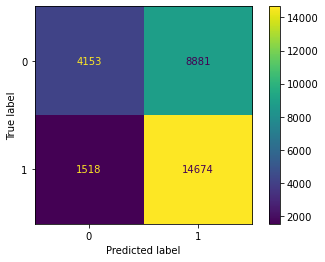

In [50]:
test_preds = logreg.predict(X_test)
test_probas = logreg.predict_proba(X_test)[:,1]

print(f"Test Acc: {logreg.score(X_test, y_test)}")
print(f"Test F1: {f1_score(y_test, test_preds)}")
print(f"Test ROCAUC: {roc_auc_score(y_test, test_probas)}")

plot_confusion_matrix(logreg, X_test, y_test);

## Decision Tree

In [51]:
tree = DecisionTreeClassifier(max_depth=5)

tree.fit(X_train, y_train)

tree.score(X_train, y_train)

0.6505959509552324

Test Acc: 0.6460685690823239
Test F1: 0.7406738868832733
Test ROCAUC: 0.6775431387338435


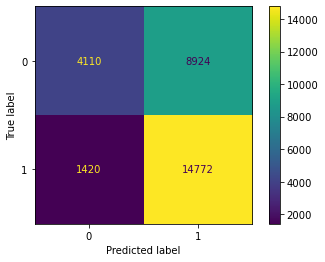

In [52]:
test_preds = tree.predict(X_test)
test_probas = tree.predict_proba(X_test)[:,1]

print(f"Test Acc: {tree.score(X_test, y_test)}")
print(f"Test F1: {f1_score(y_test, test_preds)}")
print(f"Test ROCAUC: {roc_auc_score(y_test, test_probas)}")

plot_confusion_matrix(tree, X_test, y_test);

## Random Forest

In [53]:
rf = RandomForestClassifier(max_depth=5)

rf.fit(X_train, y_train)

rf.score(X_train, y_train)

0.6555574565155403

Test Acc: 0.6527407103264217
Test F1: 0.7138950751275618
Test ROCAUC: 0.6787155508192013


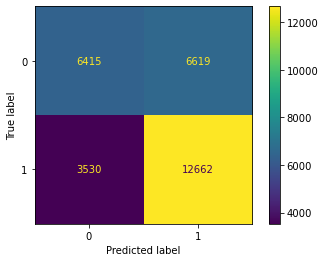

In [54]:
test_preds = rf.predict(X_test)
test_probas = rf.predict_proba(X_test)[:,1]

print(f"Test Acc: {rf.score(X_test, y_test)}")
print(f"Test F1: {f1_score(y_test, test_preds)}")
print(f"Test ROCAUC: {roc_auc_score(y_test, test_probas)}")

plot_confusion_matrix(rf, X_test, y_test);

# Save Model for Deployment

In [55]:
import pickle

In [59]:
pickle.dump(rf, open("StreamlitFiles/rf_model.sav", 'wb'))

In [60]:
# Test that out, too!
# Loading up the model
loaded_model = pickle.load(open("StreamlitFiles/rf_model.sav", 'rb'))

In [62]:
rf.score(X_test, y_test)

0.6527407103264217

In [61]:
# We can see it's the same as above
loaded_model.score(X_test, y_test)

0.6527407103264217

### Testing On a New Input

(aka what we'll need in our streamlit app!)

In [81]:
# We'll need to copy this over to streamlit
print(used_cols)

['Color_black', 'Fixed', 'Type_Cat', 'Type_Dog', 'Intake Condition_Not Normal', 'Female', 'Young']


In [65]:
# We want a new intake to look like this
X_test[:1]

,Color_black,Fixed,Type_Cat,Type_Dog,Intake Condition_Not Normal,Female,Young
101888,False,0,True,False,False,True,False


In [82]:
# Needs to match these dtypes too
X_test.dtypes

Color_black                     bool
Fixed                          int64
Type_Cat                        bool
Type_Dog                        bool
Intake Condition_Not Normal     bool
Female                          bool
Young                           bool
dtype: object

In [67]:
# Example predictions on just one 
loaded_model.predict(X_test[:1])

array([1])

In [68]:
loaded_model.predict_proba(X_test[:1])

array([[0.44639106, 0.55360894]])

In [74]:
# Example row of new inputs
example_row = [True, 0, False, True, False, False, True]

In [79]:
# Turning that into a dataframe
new_test_example = pd.DataFrame(dict(zip(used_cols, example_row)), index=[0])
new_test_example

,Color_black,Fixed,Type_Cat,Type_Dog,Intake Condition_Not Normal,Female,Young
0,True,0,False,True,False,False,True


In [80]:
# Proving we can use our model to predict on that!
loaded_model.predict(new_test_example)

array([1])